In [8]:
#https://github.com/jamescalam/transformers/blob/main/course/language_classification/02_sentiment_with_transformers.ipynb

In [ ]:
import_transformers

In [2]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

In [3]:
import transformers as tfm
print(tfm.__version__)

4.1.0


In [11]:
# https://ibm-learning.udemy.com/course/nlp-with-transformers/learn/lecture/25700656#overview 

In [4]:
# # Tensorflow
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import to_categorical

# So far, we have restricted the length of the text being fed into our models. Bert in particular is restricted to consuming 512 tokens per sample. For many use-cases, this is most likely not a problem - but in some cases it can be

# If we take the example of Reddit posts on the /r/investing subreddit, many of the more important posts are DD (due-diligence), which often consists of deep dives into why the author thinks a stock is a good investment or not. On these longer pieces of text, the actual sentiment from the author may not be clear from the first 512 tokens. We need to consider the full post.

# Before working through the logic that allows us to consider the full post, let's import and define everything we need to make a prediction on a single chunk of text (using much of what we covered in the last section). 

To apply sentiment analysis using the transformers library, we first need to decide on a model to use 
- as we will be applying a pretrained model, rather than starting from scratch.
The list of models available can be found at huggingface.co/models.

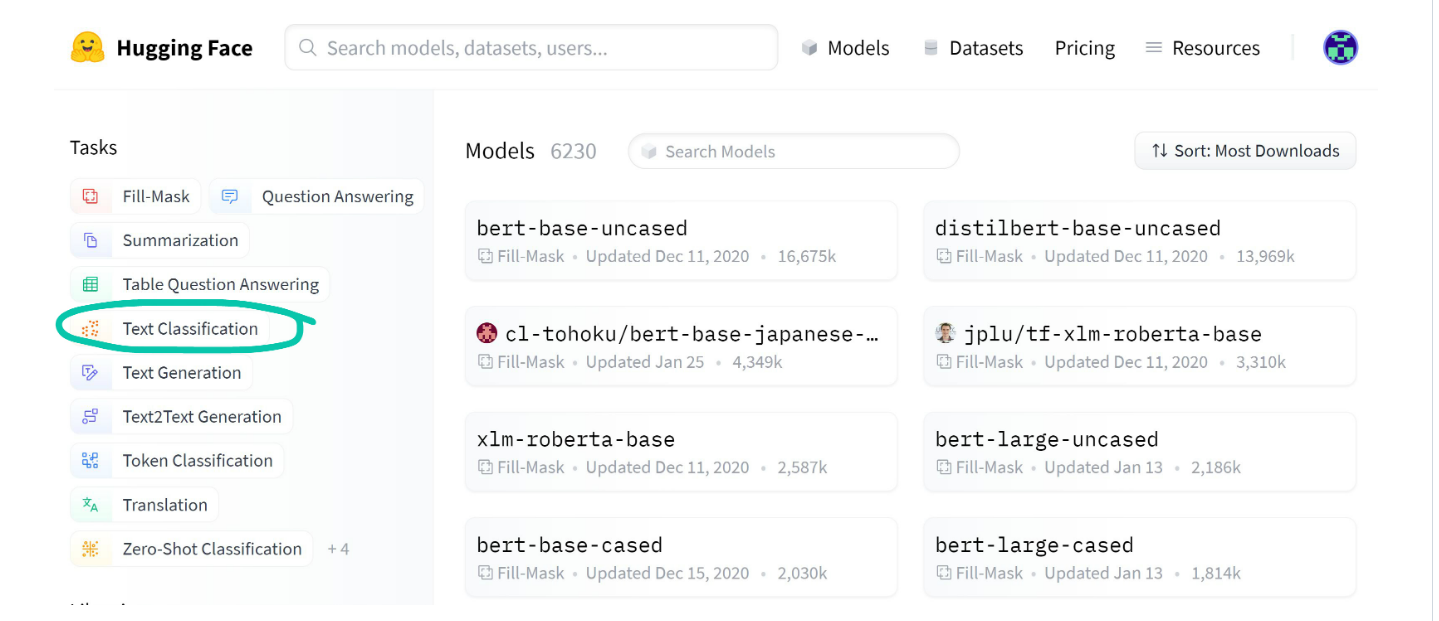

# From the model page we select the Text Classification filter on the left of the page to filter for models that we can apply for text classification tasks immediately. We will be performing sentiment analysis on posts from /r/investing (in this section we will be using the example given in txt below), which are finance oriented, so we can use the finBERT model ProsusAI/finbert which has been trained on financial articles for financial sentiment classification.

# FinBERT is ofcourse a BERT model, so when loading the model and tokenizer we will using BERT classes, and because we are performing sequence classification we will be using BertForSequenceClassification. Let's initialize our model and tokenizer:

In [3]:
# initialize our model and tokenizer
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
# initialize the model for sequence classification
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [4]:
tokenizer 

PreTrainedTokenizer(name_or_path='ProsusAI/finbert', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [5]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# The first time that this is run when using the ProsusAI/finbert model, it will be downloaded from the HuggingFace model repositories.

# 1.We tokenize our input text.(For step one, we will use the encode_plus method:)

# 2.Tokenized inputs are fed into the model, which outputs final layer activations (note activations are not probabilities).

# 3.Convert those activations into probabilities using a softmax function (sigmoid for multiple classes).

# 4.Take the argmax of those probabilities.

# 5.(Optional) Extract the probability of the winning class.

In [6]:
# this is our example text
txt = ("Given the recent downturn in stocks especially in tech which is likely to persist as yields keep going up, "
       "I thought it would be prudent to share the risks of investing in ARK ETFs, written up very nicely by "
       "[The Bear Cave](https://thebearcave.substack.com/p/special-edition-will-ark-invest-blow). The risks comes "
       "primarily from ARK's illiquid and very large holdings in small cap companies. ARK is forced to sell its "
       "holdings whenever its liquid ETF gets hit with outflows as is especially the case in market downturns. "
       "This could force very painful liquidations at unfavorable prices and the ensuing crash goes into a "
       "positive feedback loop leading into a death spiral enticing even more outflows and predatory shorts.")

tokens = tokenizer.encode_plus(txt, max_length=512, truncation=True, padding='max_length',
                               add_special_tokens=True, return_tensors='pt')

In [7]:
tokens

{'input_ids': tensor([[  101,  2445,  1996,  3522,  2091, 22299,  1999, 15768,  2926,  1999,
          6627,  2029,  2003,  3497,  2000, 29486,  2004, 16189,  2562,  2183,
          2039,  1010,  1045,  2245,  2009,  2052,  2022, 10975, 12672,  3372,
          2000,  3745,  1996, 10831,  1997, 19920,  1999, 15745,  3802, 10343,
          1010,  2517,  2039,  2200, 19957,  2011,  1031,  1996,  4562,  5430,
          1033,  1006, 16770,  1024,  1013,  1013,  1996,  4783,  2906, 27454,
          1012,  4942,  9153,  3600,  1012,  4012,  1013,  1052,  1013,  2569,
          1011,  3179,  1011,  2097,  1011, 15745,  1011, 15697,  1011,  6271,
          1007,  1012,  1996, 10831,  3310,  3952,  2013, 15745,  1005,  1055,
          5665, 18515, 21272,  1998,  2200,  2312,  9583,  1999,  2235,  6178,
          3316,  1012, 15745,  2003,  3140,  2000,  5271,  2049,  9583,  7188,
          2049,  6381,  3802,  2546,  4152,  2718,  2007,  2041, 12314,  2015,
          2004,  2003,  2926,  1996,  

Here we have specified a few arguments that require some explanation.

max_length - this tell the tokenizer the maximum number of tokens we want to see in each sample, for BERT we almost always use 512 as that is the length of sequences that BERT consumes.

truncation - if our input string txt contains more tokens than allowed (specified in max_length parameter) then we cut all tokens past the max_length limit.

padding - if our input string txt contains less tokens than specified by max_length then we pad the sequence with zeros (0 is the token ID for '[PAD]' - BERTs padding token).

add_special_tokens - whether or not to add special tokens, when using BERT we always want this to be True unless we are adding them ourselves

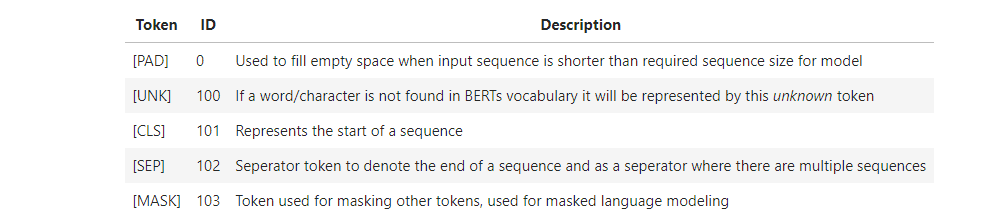

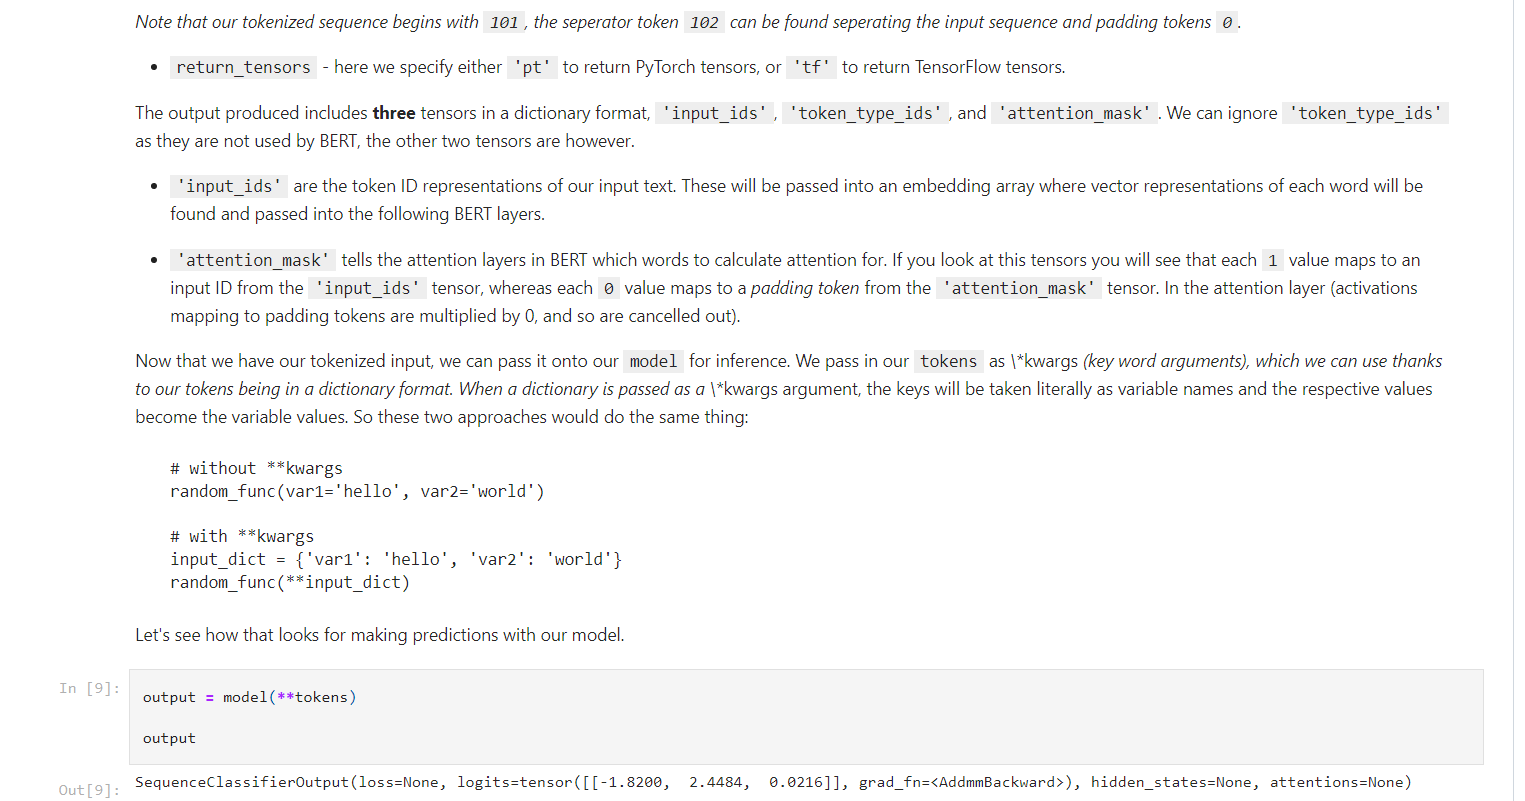

In [9]:
output=model(**tokens)

In [10]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.8200,  2.4484,  0.0216]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

# You will notice here that the output logits tensor cannot be a set of probabilities because probability values must be within the range 0-1. These are infact the final output activations from BERT, to convert these into probabilities we must apply a softmax function. We will be using the PyTorch implementation of softmax for this, which we import from torch.nn.functional

In [13]:
type(output)

transformers.modeling_outputs.SequenceClassifierOutput

In [14]:
len(output)

1

In [15]:
output[0]

tensor([[-1.8200,  2.4484,  0.0216]], grad_fn=<AddmmBackward0>)

In [16]:
import torch.nn.functional as F


In [17]:
# apply softmax to the logits output tensor of our model (in index 0) across dimension -1
probs = F.softmax(output[0], dim=-1)

probs

tensor([[0.0127, 0.9072, 0.0801]], grad_fn=<SoftmaxBackward0>)

# (We use dim=-1 as -1 signifies our tensors final dimension, so if we had a 3D tensor with dims [0, 1, 2] writing dim=-1 is the equivalent to writing dim=2. In this case if we wrote dim=-2 this would be the equivalent to writing dim=1. For a 2D tensor with dims [0, 1], dim=-1 is the equivalent of dim=1.)

# Now we have a tensor containing three classes, all with outputs within the probability range of 0-1, these are our probabilities! We can see that class index 1 has the highest probability with a value of 0.9072. We can use PyTorch's argmax function to extract this, we can use argmax after importing torch

In [18]:
import torch

pred = torch.argmax(probs)

pred

tensor(1)

# Argmax outputs our winning class as 1 as expected. To convert this value from a PyTorch tensor to a Python integer we can use the item method.

In [19]:
pred.item()

1